In [ ]:
import os
import operator
from typing import Annotated

from langchain_community.chat_models import AzureChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict

In [ ]:
OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.environ.get("AZURE_OPENAI_ENDPOINT")
OPENAI_DEPLOYMENT_VERSION = "2023-12-01-preview"

llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    model_name="gpt-4o",
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    openai_api_version=OPENAI_DEPLOYMENT_VERSION,
    openai_api_key=OPENAI_API_KEY,
    openai_api_type="azure",
    temperature=0.1,
)

In [31]:
class State(TypedDict):
    text: str
    answer: str
    payload: dict[str, list]

In [ ]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(State)


def extract_content(state: State):
    return {"text": state["payload"][0]["customer_remark"]}


def route_question_or_compliment(state: State):
    if "?" in state["text"]:
        return "question"
    else:
        return "compliment"


def run_compliment_code(state: State):
    return {"answer": "Thanks for the compliment."}


def run_question_code(state: State):
    return {"answer": "Wow nice question."}


def beautify(state: State):
    return {"answer": [state["answer"] + "beautified"]}


graph_builder.add_node("extract_content", extract_content)
graph_builder.add_node("run_question_code", run_question_code)
graph_builder.add_node("run_compliment_code", run_compliment_code)
graph_builder.add_node("beautify", beautify)

graph_builder.add_edge(START, "extract_content")
graph_builder.add_conditional_edges(
    "extract_content",
    route_question_or_compliment,
    {
        "compliment": "run_compliment_code",
        "question": "run_question_code",
    },
)
graph_builder.add_edge("run_question_code", "beautify")
graph_builder.add_edge("run_compliment_code", "beautify")
graph_builder.add_edge("beautify", END)

graph = graph_builder.compile()

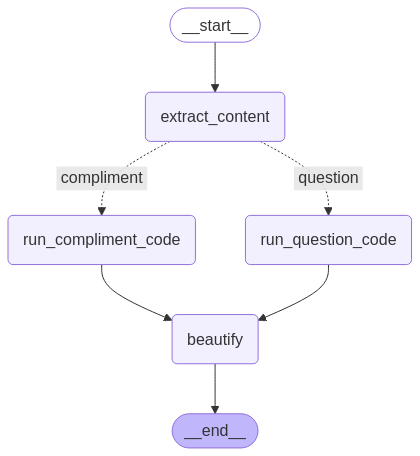

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
user_input = "I hate this."
for step in graph.stream(
    {
        "payload": [
            {
                "time_of_comment": "20-01-2025",
                "customer_remark": user_input,
                "social_media_channel": "facebook",
                "number_of_likes": 100,
            }
        ]
    }
):
    print(step)

{'extract_content': {'text': 'I hate this.'}}
{'run_compliment_code': {'answer': 'Thanks for the compliment.'}}
{'beautify': {'answer': ['Thanks for the compliment.beautified']}}


In [ ]:
graph.invoke(
    {
        "payload": [
            {
                "time_of_comment": "20-01-2025",
                "customer_remark": user_input,
                "social_media_channel": "facebook",
                "number_of_likes": 100,
            }
        ]
    }
)

{'text': 'I hate this.',
 'answer': ['Thanks for the compliment.beautified'],
 'payload': [{'time_of_comment': '20-01-2025',
   'customer_remark': 'I hate this.',
   'social_media_channel': 'facebook',
   'number_of_likes': 100}]}

How to append content to variables that are already in the state?

In [47]:
from langgraph.graph import StateGraph


class State(TypedDict):
    text: str
    # answer: str
    answer: Annotated[list, operator.add]
    payload: dict[str, list]


graph_builder = StateGraph(State)


def extract_content(state: State):
    return {"text": state["payload"][0]["customer_remark"]}


def route_question_or_compliment(state: State):
    if "?" in state["text"]:
        return "question"
    else:
        return "compliment"


def run_compliment_code(state: State):
    return {"answer": ["Thanks for the compliment."]}


def run_question_code(state: State):
    return {"answer": ["Wow nice question."]}


def beautify(state: State):
    return {"answer": [str(state["answer"][-1]) + "beautified"]}


graph_builder.add_node("extract_content", extract_content)
graph_builder.add_node("run_question_code", run_question_code)
graph_builder.add_node("run_compliment_code", run_compliment_code)
graph_builder.add_node("beautify", beautify)

graph_builder.add_edge(START, "extract_content")
graph_builder.add_conditional_edges(
    "extract_content",
    route_question_or_compliment,
    {
        "compliment": "run_compliment_code",
        "question": "run_question_code",
    },
)
graph_builder.add_edge("run_question_code", "beautify")
graph_builder.add_edge("run_compliment_code", "beautify")
graph_builder.add_edge("beautify", END)

graph2 = graph_builder.compile()

In [48]:
graph2.invoke(
    {
        "payload": [
            {
                "time_of_comment": "20-01-2025",
                "customer_remark": user_input,
                "social_media_channel": "facebook",
                "number_of_likes": 100,
            }
        ]
    }
)

{'text': 'I hate this.',
 'answer': ['Thanks for the compliment.',
  'Thanks for the compliment.beautified'],
 'payload': [{'time_of_comment': '20-01-2025',
   'customer_remark': 'I hate this.',
   'social_media_channel': 'facebook',
   'number_of_likes': 100}]}

Implement custom operators

In [54]:
def merge_dicts(dict1, dict2):
    return {**dict1, **dict2}

In [53]:
merge_dicts({"a": [1]}, {"b": 2})

{'a': [1], 'b': 2}

In [ ]:
from langgraph.graph import StateGraph


class State(TypedDict):
    text: str
    # answer: str
    # answer: Annotated[list, operator.add]
    answer: Annotated[dict, merge_dicts]
    payload: dict[str, list]


graph_builder = StateGraph(State)


def extract_content(state: State):
    return {"text": state["payload"][0]["customer_remark"]}


def route_question_or_compliment(state: State):
    if "?" in state["text"]:
        return "question"
    else:
        return "compliment"


def run_compliment_code(state: State):
    return {"answer": {"temp_answer": "Thanks for the compliment."}}


def run_question_code(state: State):
    return {"answer": {"temp_answer": "Wow nice question."}}


def beautify(state: State):
    return {
        "answer": {
            "final_beautified_answer": [
                str(state["answer"]["temp_answer"]) + "beautified"
            ]
        }
    }


graph_builder.add_node("extract_content", extract_content)
graph_builder.add_node("run_question_code", run_question_code)
graph_builder.add_node("run_compliment_code", run_compliment_code)
graph_builder.add_node("beautify", beautify)

graph_builder.add_edge(START, "extract_content")
graph_builder.add_conditional_edges(
    "extract_content",
    route_question_or_compliment,
    {
        "compliment": "run_compliment_code",
        "question": "run_question_code",
    },
)
graph_builder.add_edge("run_question_code", "beautify")
graph_builder.add_edge("run_compliment_code", "beautify")
graph_builder.add_edge("beautify", END)

graph3 = graph_builder.compile()

In [ ]:
graph3.invoke(
    {
        "payload": [
            {
                "time_of_comment": "20-01-2025",
                "customer_remark": user_input,
                "social_media_channel": "facebook",
                "number_of_likes": 100,
            }
        ]
    }
)

{'text': 'I hate this.', 'answer': {'temp_answer': 'Thanks for the compliment.'}, 'payload': [{'time_of_comment': '20-01-2025', 'customer_remark': 'I hate this.', 'social_media_channel': 'facebook', 'number_of_likes': 100}]}


{'text': 'I hate this.',
 'answer': {'temp_answer': 'Thanks for the compliment.',
  'final_beautified_answer': ['Thanks for the compliment.beautified']},
 'payload': [{'time_of_comment': '20-01-2025',
   'customer_remark': 'I hate this.',
   'social_media_channel': 'facebook',
   'number_of_likes': 100}]}

Parallel node execution

In [ ]:
from langgraph.graph import StateGraph


class State(TypedDict):
    text: str
    tag: str
    # answer: Annotated[list, operator.add]
    answer: Annotated[dict, merge_dicts]
    payload: dict[str, list]


graph_builder = StateGraph(State)


def extract_content(state: State):
    return {"text": state["payload"][0]["customer_remark"]}


def tag_query(state: State):
    if "package" in state["text"]:
        return {"tag": "Packaging"}
    elif "price" in state["text"]:
        return {"tag": "Pricing"}
    else:
        return {"tag": "General"}


def route_question_or_compliment(state: State):
    if "?" in state["text"]:
        return "question"
    else:
        return "compliment"


def run_compliment_code(state: State):
    return {"answer": {"temp_answer": "Thanks for the compliment."}}


def run_question_code(state: State):
    return {"answer": {"temp_answer": "Wow nice question."}}


def beautify(state: State):
    return {
        "answer": {
            "final_beautified_answer": [
                str(state["answer"]["temp_answer"])
                + f'I will pass it to the {state["tag"]} Department'
            ]
        }
    }


graph_builder.add_node("extract_content", extract_content)
graph_builder.add_node("tag_query", tag_query)
graph_builder.add_node("run_question_code", run_question_code)
graph_builder.add_node("run_compliment_code", run_compliment_code)
graph_builder.add_node("beautify", beautify)

graph_builder.add_edge(START, "extract_content")
graph_builder.add_edge("extract_content", "tag_query")
graph_builder.add_conditional_edges(
    "extract_content",
    route_question_or_compliment,
    {
        "compliment": "run_compliment_code",
        "question": "run_question_code",
    },
)
graph_builder.add_edge("run_question_code", "beautify")
graph_builder.add_edge("run_compliment_code", "beautify")
graph_builder.add_edge("tag_query", "beautify")
graph_builder.add_edge("beautify", END)

graph4 = graph_builder.compile()

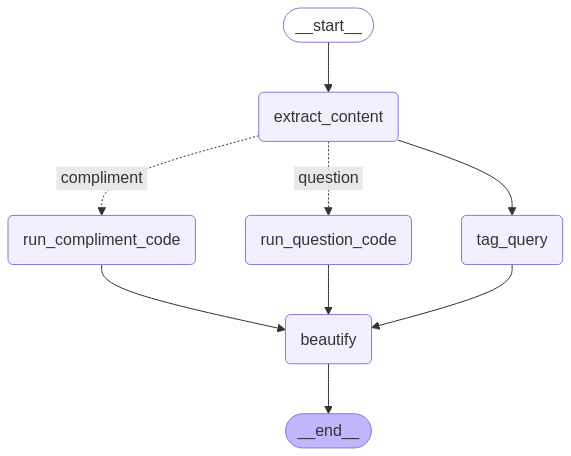

In [68]:
from IPython.display import Image, display

display(Image(graph4.get_graph().draw_mermaid_png()))

In [82]:
graph4.invoke(
    {
        "payload": [
            {
                "time_of_comment": "20-01-2025",
                "customer_remark": user_input,
                "social_media_channel": "facebook",
                "number_of_likes": 100,
            }
        ]
    }
)

{'text': 'I hate this.',
 'tag': 'General',
 'answer': {'temp_answer': 'Thanks for the compliment.',
  'final_beautified_answer': ['Thanks for the compliment.beautified.I will pass it to the General Department']},
 'payload': [{'time_of_comment': '20-01-2025',
   'customer_remark': 'I hate this.',
   'social_media_channel': 'facebook',
   'number_of_likes': 100}]}